In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
    

from uncertainties import ufloat
from uncertainties.umath import log
from uncertainties import unumpy
import scipy as sc

In [2]:
nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

In [3]:
dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

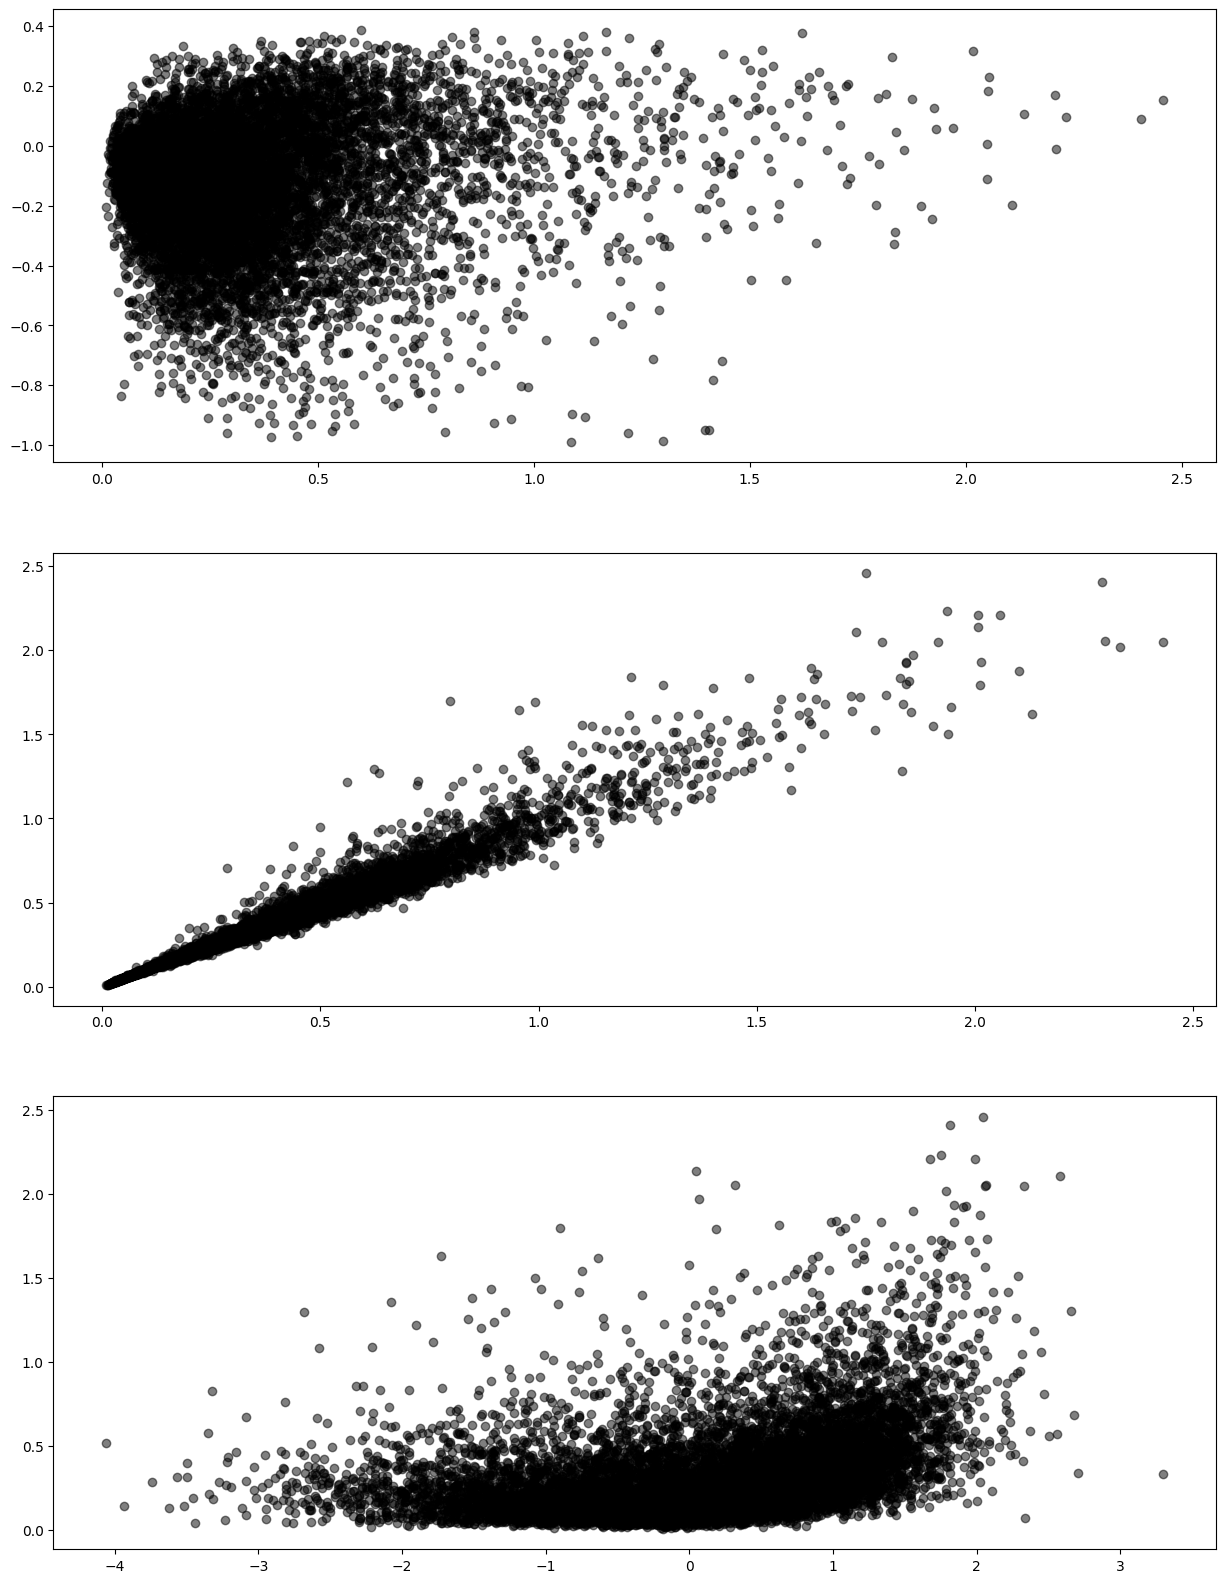

In [4]:
alpha=0.5
f, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].scatter(dust2, dust_index, c='k', alpha=0.5)
ax[1].scatter(dust1, dust2, c='k', alpha=0.5)
ax[2].scatter(recent_sfrs, dust2, c='k', alpha=0.5)

In [6]:
def create_gp_model(lengthscale, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def create_gp_model_obs(lengthscale, train_x, train_y, noise):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

def gp_evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    f_preds = model(test_x.to(torch.double))

    return f_preds

def gp_plot_confidence(f_preds, test_x, train_x, train_y, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.scatter(train_x.numpy(), train_y.numpy(), c='k', alpha=alpha)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)


def gp_plot_confidence_obs(f_preds, test_x, train_x, train_y, train_yerrs, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.errorbar(train_x.numpy(), train_y.numpy(), train_yerrs.numpy(), fmt='ko', capsize=2)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)

def binned_weighted_mean_std(x, y, yerr, bins):

    bin_midpoints = (bins[:-1]+bins[1:])/2
    nbins = len(bins)-1
    bin_indexes = np.digitize(x, bins)-1

    weighted_averages = []
    error = []
    non_empty_bins = []
    for bin in range(nbins):

        y_indexes = np.where(bin_indexes == bin)[0]

        if(len(y_indexes)> 0):
            y_in_bin = y[y_indexes]
            yerrs_in_bin = yerr[y_indexes]
            weights_in_bin = (1/yerrs_in_bin)**2
            weighted_average_in_bin = np.average(y_in_bin, weights=weights_in_bin)
            #error_on_wmean = np.sqrt(1/np.sum(weights_in_bin))
            std_in_bin = np.std(y_in_bin)
            avg_err_in_bin = np.mean(yerrs_in_bin)
            weighted_averages.append(weighted_average_in_bin)
            #set error floor
            if(std_in_bin<avg_err_in_bin):
                error.append(avg_err_in_bin)
            else:
                error.append(std_in_bin)
            non_empty_bins.append(bin_midpoints[bin])

    return np.array(non_empty_bins), np.array(weighted_averages), np.array(error)

3.4390312940090473
3.2884925476475706
3.1345474791525914
2.977615535039961
2.818218361738774
2.6569116937920363
2.494311709734761
2.3310833740622825
2.167936465058019
2.0056184679568174
1.8449067302647115
1.6865995510467764
1.5315063929884984
1.380437193430509
1.2341910058185706
1.093544238978803
0.9592385240247164
0.8319686893812704
0.7123711308119954
0.6010123338706406
0.49837787021313124
0.4048618965123889
0.32075704579077036
0.24624477713932055
0.18138612068231863
0.12611270311703882
0.08021838330037169
0.04335200257238799
0.015012390846425359
-0.005452770416918267
-0.01884198571981764
-0.02608623773224097
-0.028224123130726288
-0.02636780762112367
-0.022756093883627825
-0.01897321189902205
-0.015478801842610397
-0.012643932927717748
-0.010722421380115617
-0.009838539342428981
-0.00999184147093793
-0.011076817647963895
-0.012911863083782288
-0.015272045169357176
-0.017920368820498793
-0.020633760907663695
-0.02322207899655578
-0.025539281286146166
-0.027487794622784445
-0.029017110

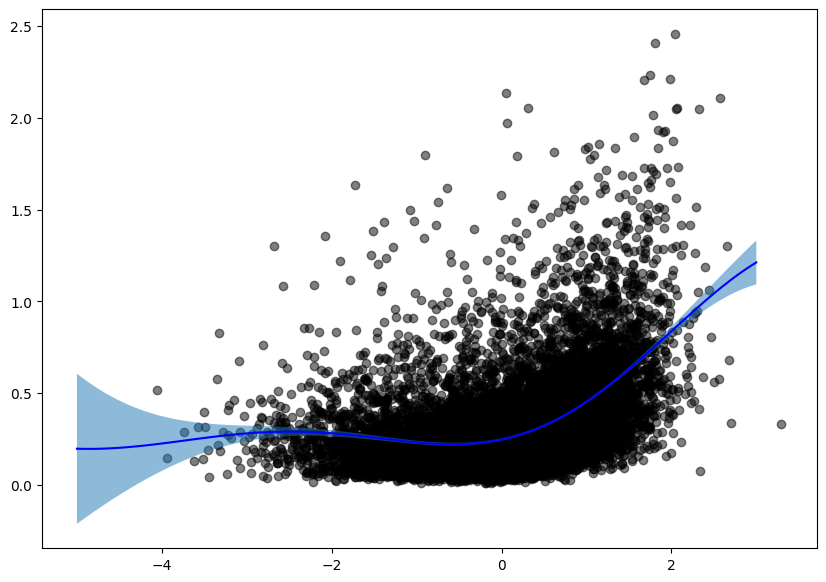

In [6]:
train_sfrs = torch.from_numpy(recent_sfrs)
train_dust2 = torch.from_numpy(dust2)
test_sfrs = torch.linspace(-5, 3, 100)
model, likelihood = create_gp_model([3.0, 15.0], train_sfrs, train_dust2)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence(f_preds, test_sfrs, train_sfrs, train_dust2, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

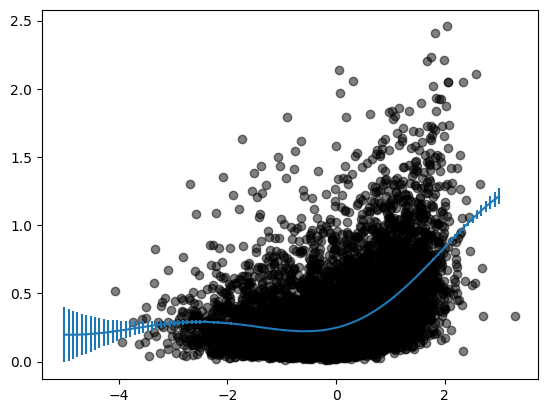

In [7]:
with torch.no_grad():
    #arr = unumpy.uarray(f_preds.mean.numpy(), f_preds.stddev.numpy())
    #arr = unumpy.exp(arr)
    #means = unumpy.nominal_values(arr)
    #stds = unumpy.std_devs(arr)
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_sfrs, means, stds)
plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


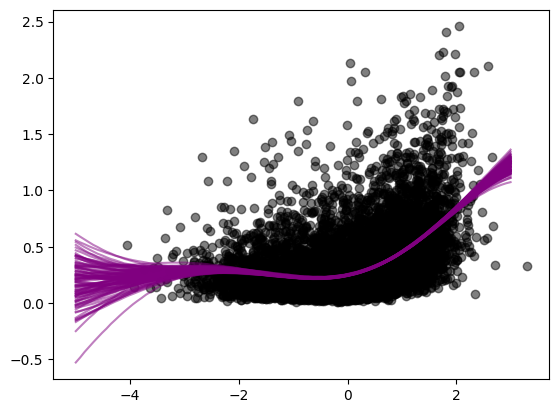

In [8]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

1.6225599746643777
1.5227911180914786
1.4220861508777285
1.3209077422077269
1.2197648103267693
1.1192084403596914
1.0198259268426555
0.9222330125686956
0.8270640492786755
0.7349595709186693
0.6465512885740662
0.5624444520169822
0.4831978739610653
0.4093025137814146
0.3411588441151542
0.27905471702432405
0.223145080011534
0.17343605929956032
0.12977612712853853
0.0918573588604023
0.059229290989545214
0.02993539486525412
0.0023942608092723016
-0.02319644194203568
-0.04664304606267299
-0.06776298876689482
-0.08639302682952087
-0.1023993304387833
-0.1156891638557455
-0.12622370834609767
-0.13403137242156857
-0.13921969111426727
-0.14198401948023467
-0.14261025773649938
-0.14146936480711786
-0.13900144256829639
-0.13568918811448724
-0.13202269220779084
-0.12845983786844348
-0.12538844957790654
-0.12309643828952223
-0.12175499327885511
-0.12141677835665553
-0.12202809685818004
-0.12345178251571444
-0.1254954517534686
-0.1279407645104847
-0.1305698397960595
-0.13318575027094567
-0.13562674337

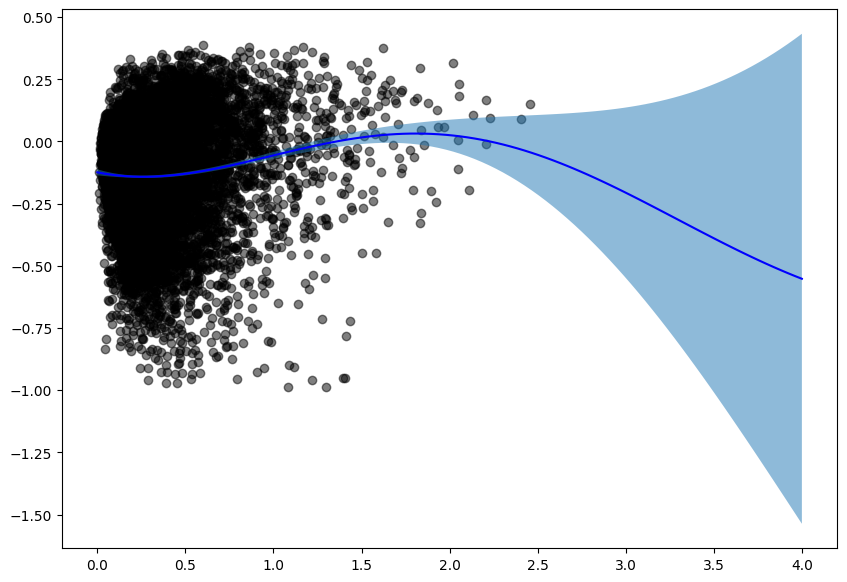

In [9]:
train_dust2 = torch.from_numpy(dust2)
train_dust_index = torch.from_numpy(dust_index)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust_index)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust_index, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

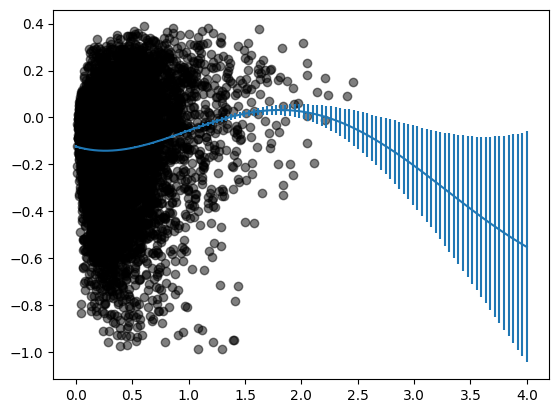

In [10]:
with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

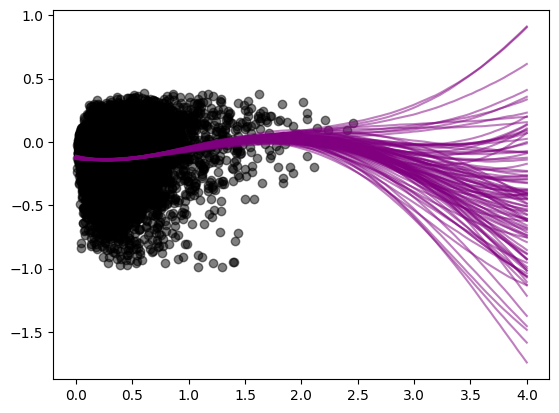

In [11]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

1.5934132041160345
1.4914055888741518
1.3882313037966136
1.2843256576981599
1.1801663856064526
1.076269333611453
0.9731821485286558
0.8714760791206865
0.7717354796376354
0.6745444192116347
0.5804714667311698
0.49005146668412153
0.4037652954583069
0.3220183367937593
0.24511694787612556
0.1732462118468281
0.10644934742076546
0.04461162197295988
-0.012548368679222962
-0.06547683422635057
-0.11476990559282278
-0.16253612195160524
-0.21051206910109954
-0.25865424018442457
-0.3069173095965748
-0.35525472156152044
-0.4036174773482027
-0.4519568883368319
-0.5002197351040684
-0.5483523504711721
-0.5962971528296652
-0.643996360129733
-0.6913852232672093
-0.7383982076995192
-0.784964756862517
-0.8310099591272015
-0.8764557197776287
-0.9212182145699016
-0.9652069846633787
-1.0083288918922109
-1.0504837263734166
-1.0915665866097375
-1.131466284242206
-1.1700683216275856
-1.2072540728052603
-1.2429006696032352
-1.2768837873120455
-1.30907926824743
-1.3393666814697567
-1.367626560438509
-1.3937516125

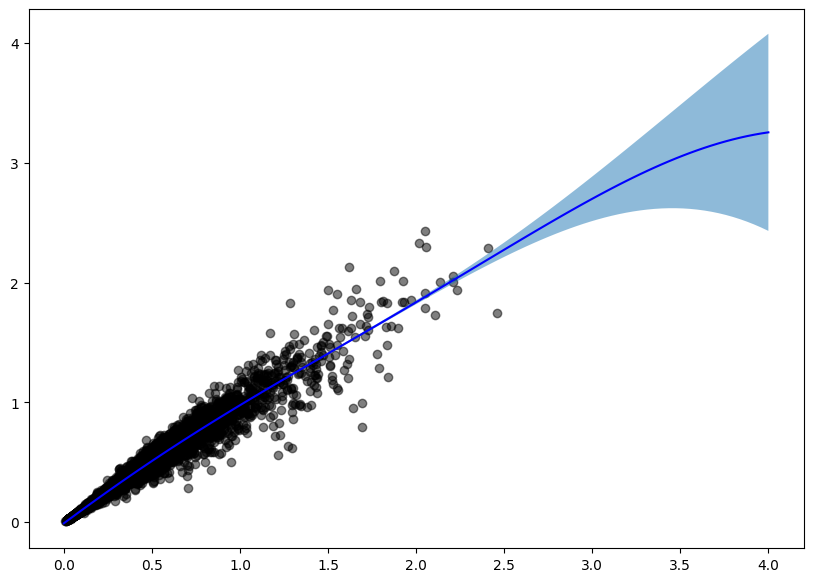

In [12]:
train_dust2 = torch.from_numpy(dust2)
train_dust1 = torch.from_numpy(dust1)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust1)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust1, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
Measured grid length from file: 20
d1 values: [0.09265918 0.16517801 0.24159316 0.32006199 0.40667442 0.49387057
 0.56470696 0.65907142 0.71992062 0.81579054 0.94977534 1.03165817
 1.11838698 1.22568968 1.34673601 1.47253277 1.5772873  1.68639503
 1.81996902 1.93449115 2.04689248 2.12317791 2.16850967 2.17415515
 2.18068492 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712 ]
d1e values: [0.05162146 0.06596811 0.05620016 0.06740064 0.06729194 0.05610234
 0.0686489

<ErrorbarContainer object of 3 artists>

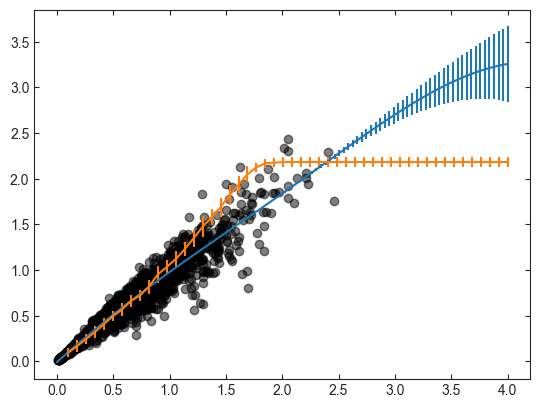

In [22]:
with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

d2 = np.linspace(0.1,4.0,50)
dobj = DustAttnCalc()
d1sim, _ = dobj.get_d1(d2)
d1, d1e = np.average(d1sim, axis=0), np.std(d1sim, axis=0)
print("d1 values:", d1)
print("d1e values:", d1e)

plt.errorbar(d2, d1, d1e)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2163: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.. Using symeig method.
  warnings.warn(


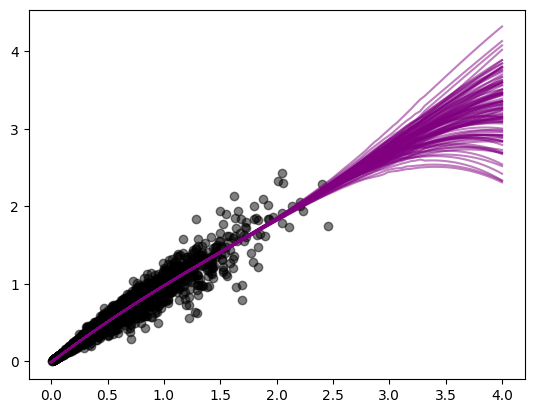

In [14]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

<ErrorbarContainer object of 3 artists>

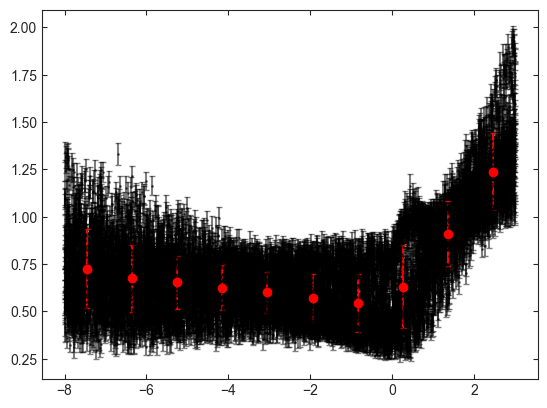

In [3]:
ngal = 10000
#sfrsamples = np.random.uniform(-8, 2, ngal)
logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-8.0,3,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

mean: 0.054332942299500225 std: 0.005806129014954288
[-7.75 -7.25 -6.75 -6.25 -5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25
 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25] [0.72303276 0.71607246 0.67626185 0.67018464 0.65436708 0.64751774
 0.63375002 0.62243517 0.61128532 0.59363187 0.59241806 0.56688871
 0.56378697 0.54200115 0.52707421 0.51256424 0.60834764 0.73594236
 0.87436382 1.02372215 1.17430145] [0.2236205  0.20088524 0.17887139 0.18036087 0.1553311  0.14494059
 0.1255361  0.12062018 0.11020786 0.10581706 0.11594968 0.12063604
 0.13026455 0.14137645 0.15630034 0.17052706 0.21821058 0.2012647
 0.14828562 0.14041452 0.15972416]


<ErrorbarContainer object of 3 artists>

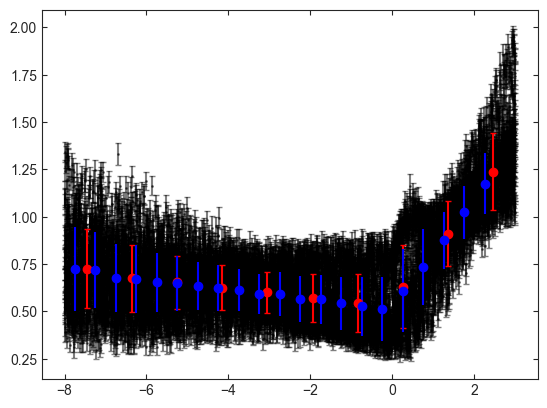

In [142]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'mean', np.linspace(-8, 3, 11))
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'std', np.linspace(-8, 3, 11))
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
sfr_bins = np.arange(-8, 3, 0.5)
x, y, yerr = binned_weighted_mean_std(sfr, tau, taue, sfr_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

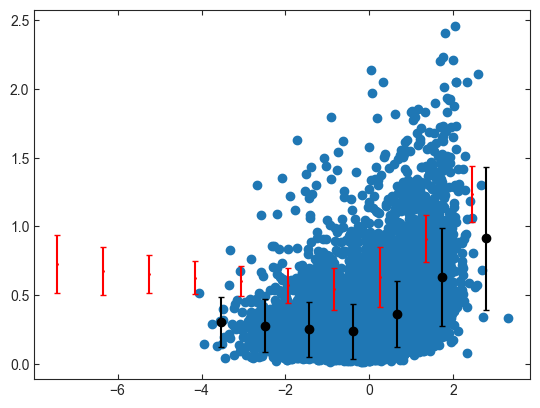

In [42]:
#sfrsamples = np.linspace(-8, 2, 20)
#dobj = DustAttnCalc(sfr=sfrsamples, bv=True, eff=False)
#dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

plt.scatter(recent_sfrs, dust2)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'mean', 7)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'std', 7)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

1566.1454394959653
1497.3397399497983
1426.807682523063
1354.7863528655816
1281.542895690564
1207.3734062590588
1132.6010275355154
1057.5732397829693
982.65835509078
908.2412491525046
834.7183832325783
762.4921948917381
691.9649633923171
623.5322790360416
557.5762632350759
494.45869801575174
434.51423004219333
378.0438162547256
325.3085778536608
276.5242281438103
231.85623806485614
191.415900557285
155.25745018548133
123.37638607817223
95.709132109335
72.13414573738619
52.47455338009575
36.50234350110136
23.94408789261867
14.48808817382653
7.792762088534642
3.4959993001423264
1.2251378343097965
0.6041678458375469
0.6023902222245473
0.600813186796499
0.5994202800337339
0.5981958631780678
0.5971248568909683
0.5961926387054567
0.5953850443001115
0.5946884306482042
0.5940897698959887
0.593576751641032
0.5931378783625326
0.5927625443356698
0.5924410926566699
0.5921648482120151
0.5919261267258301
0.5917182215812559
0.5915353710867296
0.5913727093824891
0.5912262043742372
0.5910925860388843
0

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


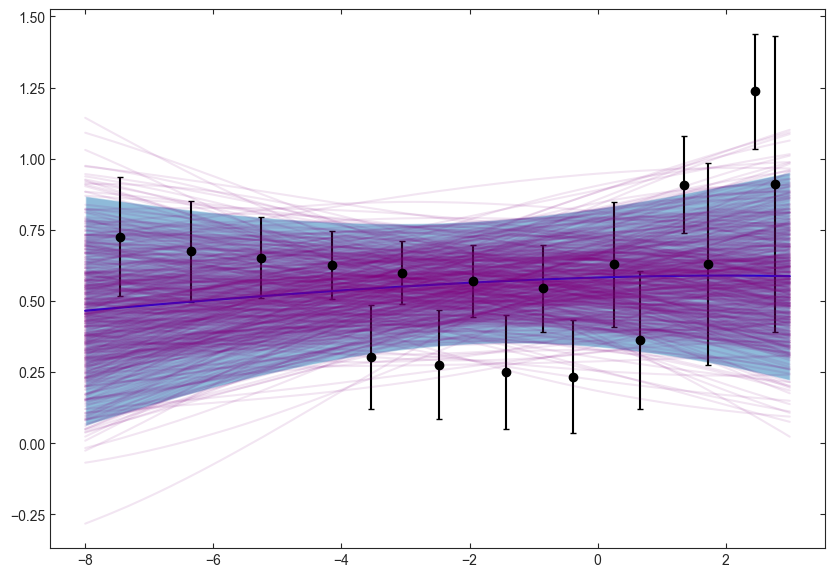

In [43]:
train_sfrs = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust2 = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust2_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_sfrs = torch.linspace(-8, 3, 100)

model, likelihood = create_gp_model_obs([3.0, 10.0], train_sfrs, train_dust2, train_dust2_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=20000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

mean: 0.04447889862555968 std: 0.0044955259679293185
[0.375 0.625 0.875 1.125 1.375 1.625 1.875] [-0.08818434 -0.15986263 -0.21288328 -0.20907563 -0.1813379  -0.13522259
 -0.12303161] [0.10002009 0.15326392 0.19206989 0.2001564  0.16140665 0.04520863
 0.04349178]


<ErrorbarContainer object of 3 artists>

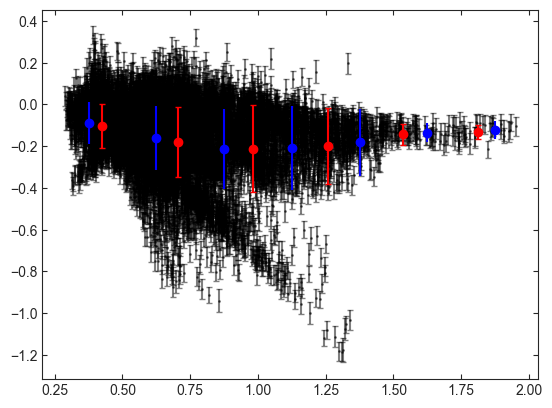

In [137]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'mean', 6)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'std', 6)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, n, ne, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

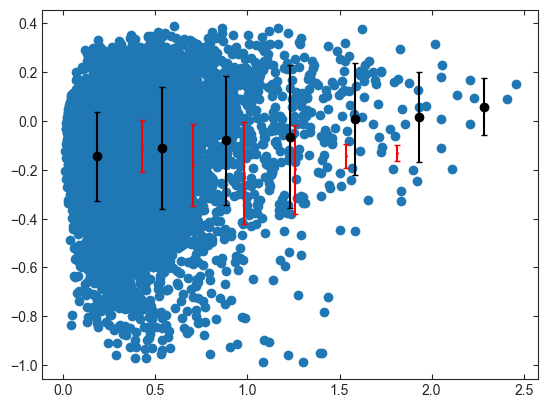

In [45]:
plt.scatter(dust2, dust_index)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'mean', 7)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'std', 7)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

657.3382772731262
606.8069958267802
555.9797447029507
505.185198281918
454.7826806787668
405.15885072907685
356.7229303383913
309.90031747432664
265.124447941936
222.82680870591594
183.4250611089297
147.30931323299586
114.82670231348843
86.26462975432311
61.83325156581914
41.64817698090122
25.71475832786511
13.915817615119126
6.005042470753268
1.6084222207421344
0.2357687742040902
0.23028432153196096
0.22550470248381188
0.22100994658345594
0.216775678189685
0.21278129808971494
0.2090092141247348
0.20544426192511284
0.2020732574175086
0.19888464313474305
0.19586820316671166
0.1930148297714563
0.19031632997495265
0.18776526398689755
0.18535480959663042
0.18307864829089457
0.18093086990706625
0.17890589336463772
0.17699840151091933
0.17520328844622657
0.1735156179093267
0.1719305914418074
0.1704435251370867
0.16904983383640046
0.16774502167576155
0.16652467792616743
0.1653844771124421
0.16432018244922297
0.16332765169835767
0.16240284463064622
0.1615418313650183
0.16074080095706236
0.1599

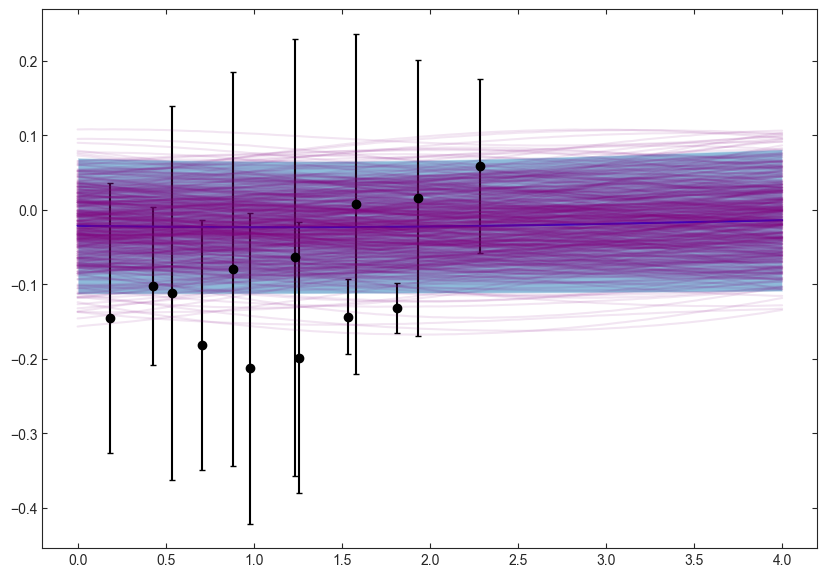

In [46]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust_index = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust_index_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([2.0, 6.0], train_dust2, train_dust_index, train_dust_index_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

mean: 0.06119499703505316 std: 0.010559312744840482
[0.375 0.625 0.875 1.125 1.375 1.625 1.875] [0.41775769 0.62805433 0.86355775 1.17296854 1.52338293 1.95229645
 2.15916547] [0.05466521 0.07421404 0.0858243  0.10014998 0.09478921 0.10382622
 0.02588968]


<ErrorbarContainer object of 3 artists>

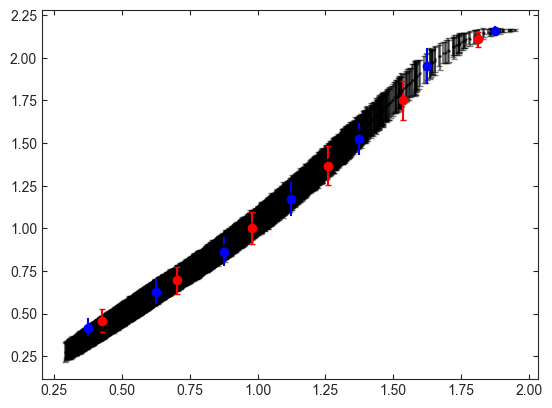

In [125]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'mean', 6)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'std', 6)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2


plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, tau1, tau1e, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')


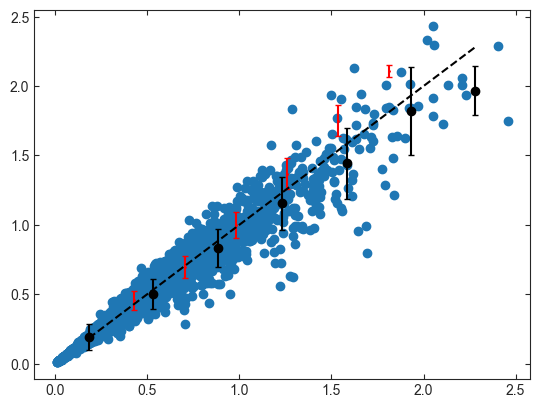

In [48]:
plt.scatter(dust2, dust1)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'mean', 7)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'std', 7)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

657.5117702656285
606.9800404382462
556.1537991086255
505.3614812245123
454.9622444478436
405.3426305976816
356.9117642702216
310.0949430112877
265.32549031190786
223.0347718038483
183.6403256674809
147.5321402692011
115.05723761220882
86.50290612143411
62.07918793389926
41.90157564267612
25.975302949789274
14.18307519431666
6.278472194574423
1.8873933890199999
0.5195886052459804
0.5198148992161147
0.5203708744342737
0.5208324106784018
0.5212007700592558
0.5214821094497183
0.5216853307266864
0.5218205918127977
0.521898307041061
0.5219285052786746
0.5219204453124685
0.5218824123771744
0.5218216388254262
0.5217443068427238
0.5216556026255991
0.5215598002383744
0.5214603599983966
0.521360031170879
0.5212609523604287
0.5211647455746231
0.521072601752825
0.5209853567966931
0.5209035579605543
0.5208275209776603
0.5207573786014285
0.5206931213957586
0.5206346316641264
0.5205817113986989
0.5205341050832525
0.5204915181144132
0.5204536315265729
0.5204201136242925
0.5203906290470482
0.5203648457

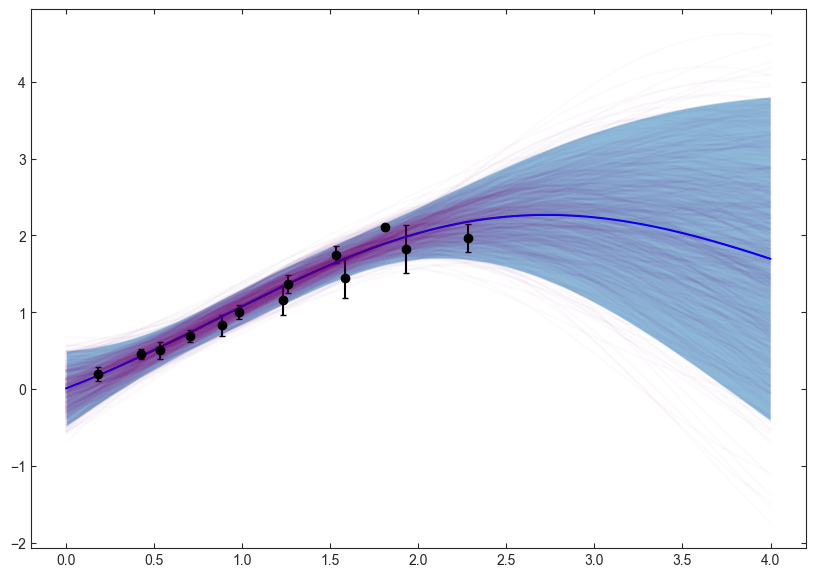

In [49]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust1 = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust1_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([2.0, 6.0], train_dust2, train_dust1, train_dust1_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)